In [1]:
import xarray as xr
import numpy as np
import seawater
import matplotlib.pyplot as plt
%matplotlib widget


<xarray.DataArray 'potential_density' ()>
array(777.50281946)


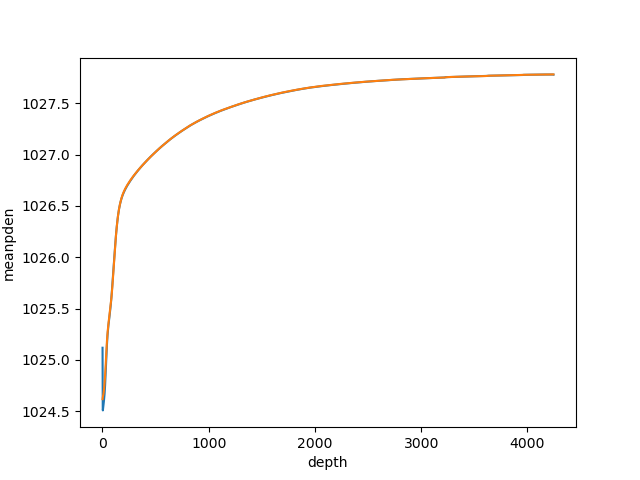

In [23]:
with xr.open_dataset('./LinePGrid.nc') as grid:
    inds = np.where((grid.mission_time >= np.datetime64('2000-01-01')) & (grid.mission_time <= np.datetime64('2020-01-01')))[0]
    grid['meanpden'] = grid.potential_density[:,inds].mean(dim=('mission_ind', 'station_ind'))
    fig, ax = plt.subplots()
    grid.meanpden.plot(ax=ax)
    inds = np.where((grid.mission_time >= np.datetime64('1990-01-01')) & (grid.mission_time <= np.datetime64('2010-01-01')))[0]
    dd = grid.potential_density[:,inds].mean(dim=('mission_ind', 'station_ind'))
    dd = dd.sortby(dd)
    grid['meanpden'] = ('depth', dd.values)
    
    grid.meanpden.plot(ax=ax)
    print(grid.potential_density.min())

In [18]:
mintime = np.datetime64('2000-01-01')
maxtime = np.datetime64('2020-01-01')
with xr.open_dataset('./LinePGrid.nc') as grid:
    inds = np.where((grid.mission_time >= mintime)  & (grid.mission_time <= maxtime))[0]
    dd = grid.potential_density[:,inds].mean(dim=('mission_ind', 'station_ind'))
    dd = dd.sortby(dd)
    grid['meanpden'] = ('depth', dd.values)
    isogrid = xr.Dataset(coords={'isodepths':grid.depth.values, 'mission_ind': grid.mission_ind.values, 'station_ind': grid.station_ind.values})
    goodpd = np.isfinite(grid.meanpden).values
    isogrid['mean_potential_density'] = ('isodepths', grid.meanpden.values)
    for k in grid.keys():
        if ('depth' in grid[k].dims) and (grid[k].ndim > 1):
            print('Yes')
            isogrid[k] = (('isodepths', 'mission_ind', 'station_ind'), np.nan * grid[k].data)
            for nn in range(len(grid.mission_ind)):
                for mm in range(len(grid.station_ind)):
                    good = (np.isfinite(grid[k][:, nn, mm] + grid.potential_density[:, nn, mm])).values
                    if np.sum(good) > 1:
                        isogrid[k][goodpd, nn, mm] = np.interp(grid.meanpden[goodpd], 
                                                      grid.potential_density[good, nn, mm].values, 
                                                      grid[k][good, nn, mm].values, left=np.nan, right=np.nan)
        elif k not in ['depth', 'meanpden']:
            isogrid[k] = grid[k]
    # get the depth
    isogrid['isopycnal_depth'] = (('isodepths', 'mission_ind', 'station_ind'), np.nan * isogrid['temperature'].data)
    for nn in range(len(grid.mission_ind)):
        for mm in range(len(grid.station_ind)):
            good = (np.isfinite(grid.potential_density[:, nn, mm])).values
            if np.sum(good) > 1:
                isogrid['isopycnal_depth'][goodpd, nn, mm] = np.interp(grid.meanpden[goodpd], 
                                              grid.potential_density[good, nn, mm].values, 
                                              grid['depth'][good].values, left=np.nan, right=np.nan)
    #isogrid = isogrid.reset_coords(['depth'])
    
    isogrid.to_netcdf('_LinePIsoGrid.nc')

Yes
Yes
Yes
Yes
Yes
Yes
Yes


PermissionError: [Errno 13] Permission denied: b'/Users/jklymak/Dropbox/LinePGrids/_LinePIsoGrid.nc'

In [19]:
isogrid.to_netcdf('_LinePIsoGrid.nc')

In [20]:
isogrid.mean_potential_density

<xarray.DataArray 'mean_potential_density' (isodepths: 5000)> Size: 40kB
array([1024.50857414, 1024.51525919, 1024.51928695, ...,           nan,
                 nan,           nan])
Coordinates:
  * isodepths  (isodepths) float64 40kB 0.5 1.5 2.5 ... 4.998e+03 5e+03

In [3]:
mintime = np.datetime64('2000-01-01')
maxtime = np.datetime64('2020-01-01')
with (xr.open_dataset('_LinePIsoGrid.nc') as isogrid, 
      xr.open_dataset('LinePGrid.nc') as grid):
    isogrid.attrs = grid.attrs.copy()
    isogrid.attrs['title'] = 'Line P cruise grid, on isopycnals'
    isogrid.attrs['history'] += ' Interpolated onto isopycnals in MakeIsoGrid.ipynb'
    isogrid.attrs['comment'] += (f' Isopycnal mean profile is average of all cruises between '
                                 f'{minttime:10s} and {maxtime:10s}')
    isogrid.isopycnal_depth.attrs = {
        'standard_name': 'depth',
        'long_name': 'depth of isopycnal [m]',
        'units': 'm',
        'positive': 'down',
        'comment': 'Depth of the isopycnal in the original CTD cast'
    }
    isogrid.isodepths.attrs = {
        'standard_name': 'depth',
        'long_name': 'depth of isopycnal [m]',
        'units': 'm',
        'positive': 'down',
        'comment': f'Depth of the isopycnal the mean.  Mean is all cruises between {minttime:10s} and {maxtime:10s}'
    }
    isogrid.mission_ind.attrs = {
        'long_name': 'mission index',
        'comment': 'index into the mission list' 
    }
    isogrid.station_ind.attrs = {
        'long_name': 'mission index',
        'comment': 'index in the station list.  Note that P1 is 0, P25 is 24 '
                   'P35 is 25 and P26 is 26.'
    }
    isogrid.temperature.attrs = {
        'standard_name': 'sea_water_temperature',
        'units': 'Celsius', 
        'long_name': 'Temperature [C]',
        'comment': 'From various CTDs so variable accuracy.  Interpolated onto mean isopycnals'
    }
    isogrid.pressure.attrs = {
        'standard_name': 'sea_water_pressure',
        'units': 'dbar',
        'long_name': 'Pressure [dbar]',
        'comment': 'Interpolated onto mean isopycnals'
    }
    isogrid.salinity.attrs = {
        'standard_name': 'sea_water_practical_salinity',
        'units': 'psu',
        'long_name': 'Salinity [psu]',
        'comment': 'From various CTDs, probably from EOS80, Interpolated onto mean isopycnals'
    }
    isogrid.oxygen.attrs = {
        'standard_name': 'mole_concentration_of_dissolved_molecular_oxygen_in_sea_water',
        'units': 'umol l-1',
        'long_name': 'O2 concentration [umol l^-1]',
        'comment': 'Many older CTDs did not have O2, Interpolated onto mean isopycnals'
    }
    isogrid.conductivity.attrs = {
        'standard_name': 'sea_water_electrical_conductivity',
        'units': 'S m-1',
        'long_name': 'Conductivity [S m^-1]',
        'comment': 'Conductivty not reported for older CTDs, Interpolated onto mean isopycnals'
    }
    isogrid.potential_density.attrs = {
        'standard_name': 'sea_water_potential_density',
        'long_name': 'potential density [kg m-3]',
        'comment': 'potential density relative to 0 dbar, using EOS80. Interpolated onto mean isopycnals',
        'units': 'kg m-3'}
    
    isogrid.potential_temperature.attrs = {
        'standard_name': 'sea_water_potential_temperature',
        'long_name': 'potential temperature [C]',
        'units': 'Celsius',
        'comment': 'potential temperature relative to 0 dbar, using EOS80. Interpolated onto mean isopycnals'
    }
    
    isogrid.time.attrs['standard_name'] = 'time'
    isogrid.time.attrs['long_name'] = 'CTD cast time'
    isogrid.mission_time.attrs['standard_name'] = 'time'
    isogrid.mission_time.attrs['long_name'] = 'Average mission time'

    isogrid.maxdepth.attrs['long_name'] = 'Maximum Cast depth'
    isogrid.maxdepth.attrs['positive'] = 'down'
    isogrid.maxdepth.attrs['comment'] = 'Maximum cast depth for this station for this mission'

    isogrid.alongx.attrs['long_name'] = 'distance along line P [km]'
    isogrid.alongx.attrs['units'] = 'km'
    isogrid.alongx.attrs['comment'] = ('km along LineP; P1=0, P26=-1423; negative '
                             'because lineP goes to the west')
    
    isogrid.station_alongx.attrs['long_name'] = 'distance along line P [km]'
    isogrid.station_alongx.attrs['units'] = 'km'
    isogrid.station_alongx.attrs['comment'] = ('Nominal station km along LineP; P1=0, P26=-1423; negative '
                             'because lineP goes to the west')

    isogrid.latitude.attrs = {'long_name': 'latitude [N]',
                           'standard_name': 'latitude',
                           'units':        'degrees_north'}
    
    isogrid.longitude.attrs = {'long_name': 'longitude [E]',
                           'standard_name': 'longitude',
                           'units':        'degrees_east',
                           'comment': 'west is less than zero'}

    isogrid.station_id.attrs = {'long_name': 'Station Name'}
    isogrid.mission.attrs = {'long_name': 'Mission Name',
                         'comment': 'IOS mission name. Note these '
                                    'are not necessarily in chronological '
                                    'order'}
    isogrid.mission.attrs = {'long_name': 'Mission Name',
                         'comment': 'IOS mission name. Note these '
                                    'are not necessarily in chronological '
                                    'order'}
    
    # get station lon and lat
    with xr.open_dataset('LinePStations.nc') as stations:
        isogrid['station_lon'] = ('station_ind', stations.lon.data)
        isogrid.station_lon.attrs = {'long_name': 'longitude [E]',
                           'standard_name': 'longitude',
                           'units':        'degrees_east',
                           'comment': 'Nominal station location. west is less than zero'}

        isogrid['station_lat'] = ('station_ind', stations.lat.data)
        isogrid.station_lat.attrs = {'long_name': 'latitude [N]',
                           'standard_name': 'latitude',
                           'units':        'degrees_north',
                           'comment': 'Nominal station location'}
    isogrid['mean_potential_density'].attrs = {
        'long_name': 'mean potential density [kg m^-3]',
        'units': 'kg m-3',
        'comment': f'density of this isopycnal:  Mean from {mintime:10s} to {maxtime:10s}'
    }
    display(isogrid)
    isogrid.to_netcdf('LinePIsoGrid.nc')

<xarray.Dataset> Size: 2GB
Dimensions:                   (isodepths: 5000, mission_ind: 204,
                               station_ind: 27)
Coordinates:
  * isodepths                 (isodepths) float64 40kB 0.5 1.5 ... 5e+03
  * mission_ind               (mission_ind) int64 2kB 1 4 5 7 ... 503 511 513
  * station_ind               (station_ind) int64 216B 0 1 2 3 4 ... 23 24 25 26
Data variables: (12/28)
    mean_potential_density    (isodepths) float64 40kB ...
    temperature               (isodepths, mission_ind, station_ind) float64 220MB ...
    pressure                  (isodepths, mission_ind, station_ind) float64 220MB ...
    salinity                  (isodepths, mission_ind, station_ind) float64 220MB ...
    oxygen                    (isodepths, mission_ind, station_ind) float64 220MB ...
    conductivity              (isodepths, mission_ind, station_ind) float64 220MB ...
    ...                        ...
    station_name              (station_ind) <U3 324B ...
    potential_density         (isodepths, mission_ind, station_ind) float64 220MB ...
    potential_temperature     (isodepths, mission_ind, station_ind) float64 220MB ...
    station_lon               (station_ind) float64 216B -125.5 ... -145.0
    station_lat               (station_ind) float64 216B 48.58 48.6 ... 50.0
    isopycnal_depth           (isodepths, mission_ind, station_ind) float64 220MB ...
Attributes: (12/15)
    Conventions:               CF-1.11
    title:                     Line P cruise grid, on isopycnals
    institution:               Institute of Ocean Sciences, Sidney, BC, Canada
    creator:                   Jody Klymak
    creator_institution:       University of Victoria, BC, Canada
    email:                     jklymak@uvic.ca
    ...                        ...
    references:                https://github.com/jklymak/LinePGrid/
    keywords:                  CTD, Oceans, Ocean Pressure, Water Pressure, O...
    keywords_vocabulary:       GCMD Science Keywords
    license:                   This data may be redistributed and used withou...
    sea_name:                  Coastal Waters of Southeast Alaska and British...
    standard_name_vocabulary:  CF STandard Name Table v85

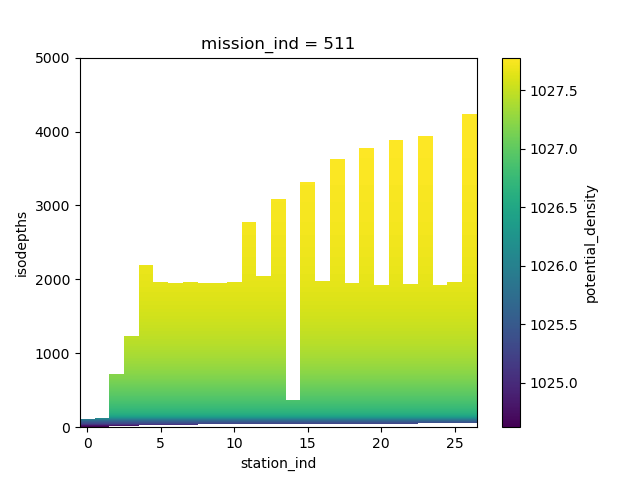

In [16]:
fig, ax = plt.subplots()
isogrid.potential_density.isel(mission_ind=-2).plot.pcolormesh()

In [5]:
grid

<xarray.Dataset>
Dimensions:                   (depth: 5000, mission_ind: 204, station_ind: 27,
                               depths: 5000)
Coordinates:
  * depth                     (depth) float64 0.5 1.5 2.5 ... 4.998e+03 5e+03
  * mission_ind               (mission_ind) int64 1 4 5 7 8 ... 501 503 511 513
  * station_ind               (station_ind) int64 0 1 2 3 4 5 ... 22 23 24 25 26
Dimensions without coordinates: depths
Data variables: (12/25)
    temperature               (depth, mission_ind, station_ind) float64 nan ....
    pressure                  (depth, mission_ind, station_ind) float64 nan ....
    salinity                  (depth, mission_ind, station_ind) float64 nan ....
    oxygen                    (depth, mission_ind, station_ind) float64 nan ....
    conductivity              (depth, mission_ind, station_ind) float64 nan ....
    time                      (mission_ind, station_ind) datetime64[ns] ...
    ...                        ...
    mission                   (mission_ind) |S8 ...
    mission_time              (mission_ind) datetime64[ns] 1968-08-11T07:07:0...
    station_name              (station_ind) object ...
    potential_density         (depth, mission_ind, station_ind) float64 nan ....
    potential_temperature     (depths, mission_ind, station_ind) float64 ...
    meanpden                  (depth) float64 1.025e+03 1.025e+03 ... nan nan

/var/folders/kx/4c3bx_w92t31pqyvg6ws03200000gn/T/ipykernel_10199/56226811.py:19: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pc = ax.pcolormesh(isogrid.mission_time, isogrid.isodepths, dt, vmax=2, vmin=-2, cmap='RdBu_r', rasterized=True)
/var/folders/kx/4c3bx_w92t31pqyvg6ws03200000gn/T/ipykernel_10199/56226811.py:19: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pc = ax.pcolormesh(isogrid.mission_time, isogrid.isodepths, dt, vmax=2, vmin=-2, cmap='RdBu_r', rasterized=True)
/var/folders/kx/4c3bx_w92t31pqyvg6ws03200000gn/T/ipykernel_10199/56226811.py:19: UserWarning: The input coor

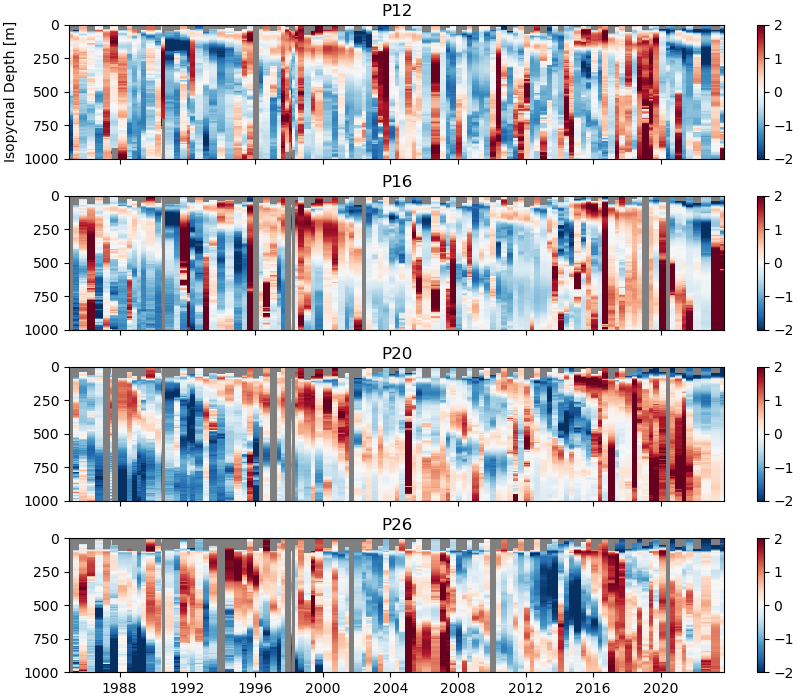

In [7]:
with xr.open_dataset('LinePIsoGrid.nc') as isogrid:
    tds = [11, 15, 19, -1]
    p26 = isogrid.isel(station_ind=19)
    
    tind = np.where((p26.mission_time.values >= np.datetime64('1990-01-01')) & (p26.mission_time.values <= np.datetime64('2020-01-01')))[0]

    meanT = p26.potential_temperature.isel(mission_ind=tind).mean(dim='mission_ind')
    stT = p26.potential_temperature.isel(mission_ind=tind).std(dim='mission_ind')
        
    fig, axs = plt.subplots(len(tds), 1, figsize=(8, 7), layout='constrained', sharex=True, sharey=True)
    for nn, td in enumerate(tds):
        ax = axs[nn]
        p26 = isogrid.isel(station_ind=td)
        
        tind = np.where((p26.mission_time.values >= np.datetime64('1990-01-01')) & (p26.mission_time.values <= np.datetime64('2020-01-01')))[0]
        meanT = p26.potential_temperature.isel(mission_ind=tind).mean(dim='mission_ind')
        stT = p26.potential_temperature.isel(mission_ind=tind).std(dim='mission_ind')
        dt = (p26.potential_temperature - meanT) / stT
        pc = ax.pcolormesh(isogrid.mission_time, isogrid.isodepths, dt, vmax=2, vmin=-2, cmap='RdBu_r', rasterized=True)
        ax.set_ylim([3000, 0])
        ax.set_xlim(left=np.datetime64('1985-01-01'))
        ax.set_facecolor('0.5')
        ax.set_title(p26.station_id.values)
        fig.colorbar(pc)
    axs[0].set_ylabel('Isopycnal Depth [m]')
    fig.savefig('TempAnomNorm.pdf')
    axs[0].set_ylim([1000, 0])
    fig.savefig('TempAnomNorm1000.pdf')
    

/var/folders/kx/4c3bx_w92t31pqyvg6ws03200000gn/T/ipykernel_8366/3147789611.py:9: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pc = ax.pcolormesh(isogrid.mission_time, isogrid.isodepths, dt, vmax=0.5, vmin=-0.5, cmap='RdBu_r')


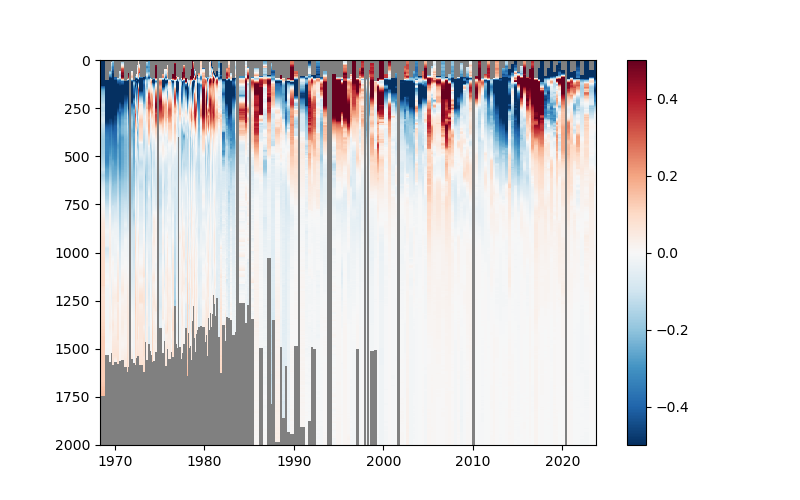

In [50]:
with xr.open_dataset('LinePIsoGrid.nc') as isogrid:
    fig, ax = plt.subplots(figsize=(8, 5))
    p26 = isogrid.isel(station_ind=26)
    
    tind = np.where((p26.mission_time.values >= np.datetime64('1990-01-01')) & (p26.mission_time.values <= np.datetime64('2020-01-01')))[0]
    meanT = p26.temperature.isel(mission_ind=tind).mean(dim='mission_ind')
    stT = p26.temperature.isel(mission_ind=tind).std(dim='mission_ind')
    dt = (p26.temperature - meanT)
    pc = ax.pcolormesh(isogrid.mission_time, isogrid.isodepths, dt, vmax=0.5, vmin=-0.5, cmap='RdBu_r')
    ax.set_ylim([2000, 0])
    ax.set_facecolor('0.5')
    fig.colorbar(pc)

In [61]:
!ls -halt LineP*.nc

-rw-r--r--@ 1 jklymak  staff   1.2G 26 Aug 18:19 LinePIsoGrid.nc
-rw-r--r--@ 1 jklymak  staff   1.2G 26 Aug 16:47 LinePGrid.nc


In [60]:
!rm LinePGridSm.nc

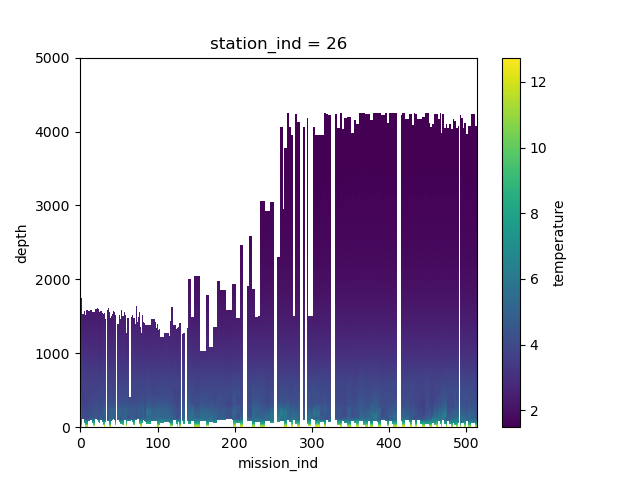

In [62]:
fig, ax = plt.subplots()
isogrid.temperature.isel(station_ind=-1).plot(ax=ax)

In [63]:
stp26= isogrid.isel(station_ind=-1)

In [64]:
stp26

<xarray.Dataset>
Dimensions:                   (isodepths: 5000, mission_ind: 204, depth: 5000)
Coordinates:
  * isodepths                 (isodepths) float64 0.5 1.5 ... 4.998e+03 5e+03
  * mission_ind               (mission_ind) int64 1 4 5 7 8 ... 501 503 511 513
    station_ind               int64 26
  * depth                     (depth) float64 0.5 1.5 2.5 ... 4.998e+03 5e+03
Data variables: (12/24)
    temperature               (depth, mission_ind) float64 11.71 nan ... nan nan
    pressure                  (depth, mission_ind) float64 13.96 nan ... nan nan
    salinity                  (depth, mission_ind) float64 32.39 nan ... nan nan
    oxygen                    (depth, mission_ind) float64 nan nan ... nan nan
    conductivity              (depth, mission_ind) float64 nan nan ... nan nan
    time                      (mission_ind) datetime64[ns] ...
    ...                        ...
    furthest                  (mission_ind) float64 ...
    mission                   (mission_ind) |S8 ...
    mission_time              (mission_ind) datetime64[ns] 1968-08-11T07:07:0...
    station_name              object ...
    potential_density         (depth, mission_ind) float64 1.025e+03 nan ... nan
    meanpden                  (depth) float64 1.025e+03 1.025e+03 ... nan nan